<a href="https://colab.research.google.com/github/irenetobby/intermediate-assesement_2/blob/main/Intermediate_assessment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
# Dream Housing Finance - Loan Eligibility Prediction


import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer


# 1. Load Data

train = pd.read_csv('/content/train_ctrUa4K.csv')
test = pd.read_csv('/content/test_lAUu6dG.csv')

# Save Loan_ID for submission
test_loan_id = test['Loan_ID']


# 2. Data Preprocessing


# Combine train & test for uniform preprocessing
data = pd.concat([train.drop('Loan_Status', axis=1), test])

# Handling missing values
categorical_cols = data.select_dtypes(include='object').columns
numerical_cols = data.select_dtypes(include=['int64', 'float64']).columns

# Impute categorical with mode
for col in categorical_cols:
    data[col] = data[col].fillna(data[col].mode()[0])

# Impute numerical with median
for col in numerical_cols:
    data[col] = data[col].fillna(data[col].median())

# Feature Engineering
data['TotalIncome'] = data['ApplicantIncome'] + data['CoapplicantIncome']
data['LoanAmount_log'] = np.log1p(data['LoanAmount'])
data['TotalIncome_log'] = np.log1p(data['TotalIncome'])

# Drop unused columns
data.drop(['Loan_ID'], axis=1, inplace=True)

# Label Encoding
le = LabelEncoder()
for col in categorical_cols:
    if col != 'Loan_ID':
        data[col] = le.fit_transform(data[col])

# Split back to train & test
X = data.iloc[:train.shape[0], :]
X_test = data.iloc[train.shape[0]:, :]
y = train['Loan_Status'].map({'Y':1, 'N':0})


# 3. Model Training
model = RandomForestClassifier(
    n_estimators=300,
    max_depth=10,
    random_state=42
)

model.fit(X, y)

# Training Accuracy
train_pred = model.predict(X)
print("Training Accuracy:", accuracy_score(y, train_pred))


# 4. Prediction


test_pred = model.predict(X_test)
test_pred = np.where(test_pred == 1, 'Y', 'N')


# 5. Submission File


submission = pd.DataFrame({
    'Loan_ID': test_loan_id,
    'Loan_Status': test_pred
})

submission.to_csv('final_submission.csv', index=False)

print("Submission file created successfully!")

Training Accuracy: 0.9087947882736156
Submission file created successfully!


In [10]:
from xgboost import XGBClassifier

model = XGBClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=4,
    random_state=42
)

model.fit(X, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=500,
              n_jobs=None, num_parallel_tree=None, ...)

In [6]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
print("CV Accuracy:", scores.mean())


CV Accuracy: 0.7801412768226044


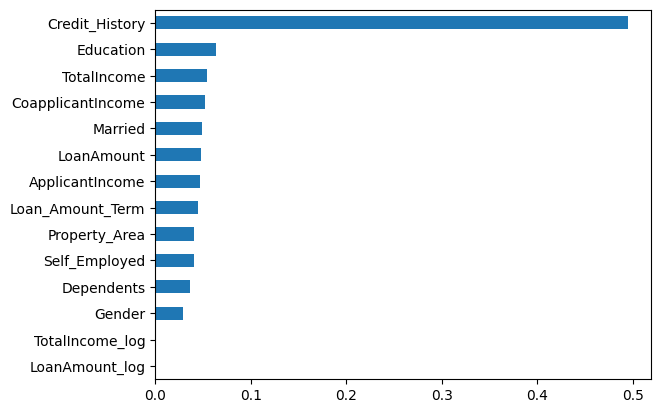

In [12]:
import matplotlib.pyplot as plt
importances = model.feature_importances_
feat_importances = pd.Series(importances, index=X.columns)
feat_importances.sort_values().plot(kind='barh')
plt.show()

In [22]:

# Loan Eligibility - Model Accuracy Comparison


import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer

# If using XGBoost (install first in Colab if needed)
# !pip install xgboost
from xgboost import XGBClassifier


# 1. Load Data


train = pd.read_csv('/content/train_ctrUa4K.csv')


# 2. Preprocessing


# Handle missing values
for col in train.columns:
    if train[col].dtype == 'object':
        train[col] = train[col].fillna(train[col].mode()[0])
    else:
        train[col] = train[col].fillna(train[col].median())

# Feature Engineering
train['TotalIncome'] = train['ApplicantIncome'] + train['CoapplicantIncome']
train['LoanAmount_log'] = np.log1p(train['LoanAmount'])
train['TotalIncome_log'] = np.log1p(train['TotalIncome'])

# Encode categorical variables
le = LabelEncoder()
for col in train.select_dtypes(include='object').columns:
    train[col] = le.fit_transform(train[col])

# Features & Target
X = train.drop(['Loan_ID', 'Loan_Status'], axis=1)
y = train['Loan_Status']

# Train/Test Split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


# 3. Credit_History Baseline


credit_pred = X_val['Credit_History']
baseline_acc = accuracy_score(y_val, credit_pred)

print("Credit_History Baseline Accuracy:", round(baseline_acc*100, 2), "%")


# 4. Logistic Regression


log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train, y_train)
log_pred = log_model.predict(X_val)

log_acc = accuracy_score(y_val, log_pred)
print("Logistic Regression Accuracy:", round(log_acc*100, 2), "%")

# Cross Validation
log_cv = cross_val_score(log_model, X, y, cv=5, scoring='accuracy')
print("Logistic Regression CV Accuracy:", round(log_cv.mean()*100, 2), "%")


# 5. Random Forest


rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=10,
    random_state=42
)

rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_val)

rf_acc = accuracy_score(y_val, rf_pred)
print("Random Forest Accuracy:", round(rf_acc*100, 2), "%")

rf_cv = cross_val_score(rf_model, X, y, cv=5, scoring='accuracy')
print("Random Forest CV Accuracy:", round(rf_cv.mean()*100, 2), "%")


# 6. XGBoost (Tuned)


xgb_model = XGBClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=4,
    random_state=42,
    eval_metric='logloss'
)

xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_val)

xgb_acc = accuracy_score(y_val, xgb_pred)
print("XGBoost Accuracy:", round(xgb_acc*100, 2), "%")

xgb_cv = cross_val_score(xgb_model, X, y, cv=5, scoring='accuracy')
print("XGBoost CV Accuracy:", round(xgb_cv.mean()*100, 2), "%")

Credit_History Baseline Accuracy: 85.37 %


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy: 86.18 %


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Logistic Regression CV Accuracy: 80.62 %
Random Forest Accuracy: 84.55 %
Random Forest CV Accuracy: 79.97 %
XGBoost Accuracy: 80.49 %
XGBoost CV Accuracy: 78.83 %
